In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import kornia 
import matplotlib.cm
import time
import argparse
import datetime
import random

In [2]:
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=2208, decoder_width = 0.5):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)

        self.up1 = UpSample(skip_input=features//1 + 384, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 192, output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 +  96, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[11]
        x_d0 = self.conv2(x_block4)
        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.densenet161( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [3]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


class DepthDataset(Dataset):
    os = __import__('os')
    def __init__(self, traincsv, root_dir, transform=None):
        self.traincsv = traincsv
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.traincsv)

    def __getitem__(self, idx):
        
        sample = self.traincsv[idx]
        img_name = os.path.join(self.root_dir,sample[0])
        image = (Image.open(img_name))
        depth_name = os.path.join(self.root_dir,sample[1])
        depth =(Image.open(depth_name))
#         depth = depth[..., np.newaxis]
        sample1={'image': image, 'depth': depth}

        if self.transform:  sample1 = self.transform({'image': image, 'depth': depth})
        return sample1

In [4]:
class Augmentation(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        #generate some output like this [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
        self.indices = list(permutations(range(3), 3))
        #followed by randomly picking one channel in the list above
    
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(depth)))
        
        # flipping the image
        if random.random() < 0.5:
            #random number generated is less than 0.5 then flip image and depth
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)
        
        # rearranging the channels    
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])    

        return {'image': image, 'depth': depth}

In [5]:
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        

        image = self.to_tensor(image)

        depth = depth.resize((320, 240))

        if self.is_test:
            depth = self.to_tensor(depth).float() / 1000
        else:            
            depth = self.to_tensor(depth).float() * 1000
        
        # put in expected range
        depth = torch.clamp(depth, 10, 1000)

        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        pic = np.array(pic)
        if not (_is_numpy_image(pic) or _is_pil_image(pic)):
                raise TypeError(  'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
             
        if isinstance(pic, np.ndarray):
            if pic.ndim==2:
                pic=pic[..., np.newaxis]
                
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)

In [6]:
traincsv=pd.read_csv('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)


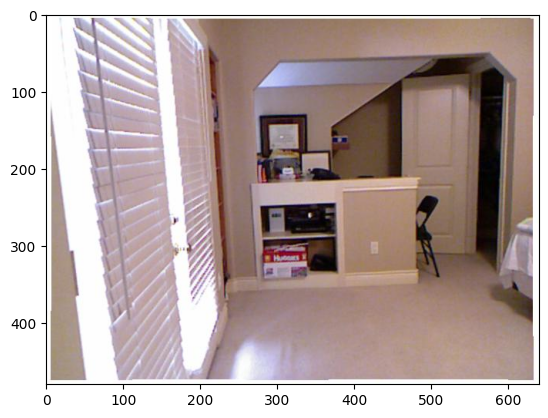

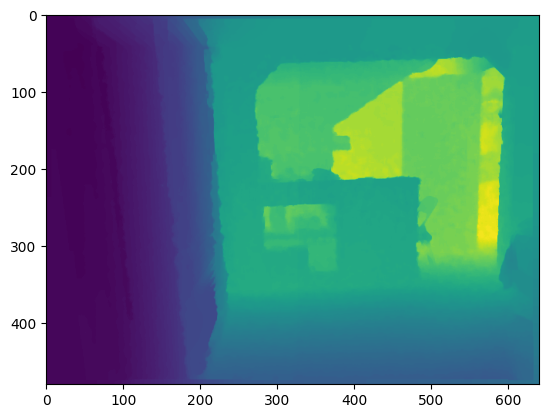

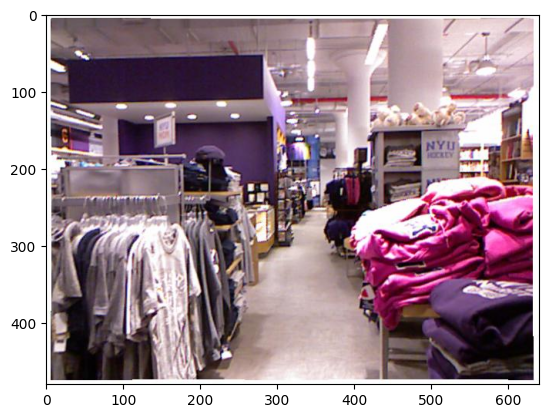

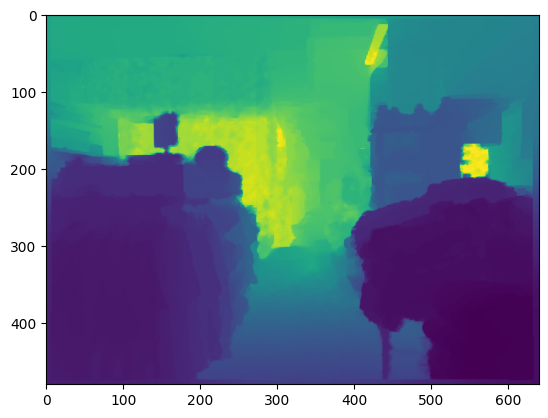

<Figure size 640x480 with 0 Axes>

In [7]:
depth_dataset = DepthDataset(traincsv=traincsv,
                                    root_dir='/kaggle/input/nyu-depth-v2/nyu_data/')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size, sample['depth'].size)


    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()


    if i == 1:
        plt.show()
        break

In [8]:
batch_size=4
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size, shuffle=True)
train_loader

In [9]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim_loss = kornia.losses.SSIMLoss(window_size=window_size, max_val=val_range, reduction='none')
    return ssim_loss(img1, img2)

In [10]:

def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [11]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output

In [12]:
model = Model().cuda()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)
print('Model created.')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 157MB/s]


Model created.


In [13]:
epochs=4
lr=0.00012
batch_size=8
optimizer = torch.optim.Adam( model.parameters(), lr )

In [14]:
depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/kaggle/input/nyu-depth-v2/nyu_data',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

In [15]:
# Training Loop
for epoch in range(epochs):
    path = f'/kaggle/working/{epoch}.pth'        
    torch.save(model.state_dict(), path)
    
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    # Initialize tqdm progress bar
    loop = tqdm(enumerate(train_loader), total=N, leave=False)

    for i, sample_batched in loop:
        optimizer.zero_grad()

        # Prepare sample and target
        image = Variable(sample_batched['image'].cuda())
        depth = Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm(depth)

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range=1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val * (N - i))))

        # Update tqdm description with current progress
        if i % 5 == 0:
            loop.set_description(f"Epoch[{epoch+1}/{epochs}]")
            loop.set_postfix(loss=losses.avg)

        # Optionally clear cache
        if i % 100 == 0:
            torch.cuda.empty_cache()

    # Save model checkpoint after each epoch
    torch.save(model.state_dict(), path)

In [16]:
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/kaggle/input/nyu-depth-v2/nyu_data',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

for sample_batched1 in train_loader:
    # Move the image and depth to GPU
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    depth1 = torch.autograd.Variable(sample_batched1['depth'].cuda())
    
    # Forward pass through the model
    output = model(image1)
    
    # Normalize the depth
    depth_n = DepthNorm(depth1)
    
    # Compute the L1 loss
    loss = l1_criterion(output, depth_n)
    
    # Print the loss
    print(f'Loss for the batch: {loss.item()}')
    
    break  # Break after the first batch for demonstration purposes

Loss for the batch: 0.5570435523986816
